# Toplotne potrebe

When2Heat set podataka se sastoji od sintetskih vremenskih nizova toplotnih potreba i koeficijenta učinka toplotnih pumpi za 16 evropskih država u periodu 2008 - 2018. na satnoj rezoluciji. Profili toplotnih potreba za grijanje prostora i PTV su izračunati na osnovu profila potrošnje gasa, temperature i brzine vjetra uz faktor populacije. U nastavku je analiza podataka koji su izdvojeni za Hrvatsku, i dostupni u periodu 2008 - 2013, s obzirom na slične parametre populacije i klimatskih uslova kao u BiH. Ovi podaci su se skupa sa ukupnim potrebama po različitim tipovima objekata iz literature iskoristili za procjenu toplotnih potreba u BiH na satnoj osnovi. Set podataka, skripte i ulazni parametri su dostupni na Open Power System Data platform.
https://open-power-system-data.org/
https://github.com/oruhnau/when2heat
https://www.nature.com/articles/s41597-019-0199-y.pdf

Metodologija po kojoj je napravljen uzorak za Hrvatsku i druge države će biti naknadno ubačena u ovaj fajl. Donekle je dešifrovana, međutim, problem predstavlja nemogućnost sagledavanja geografskih podataka što djelimično otežava potpuno razumijevanje algoritma.

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file=pd.read_excel(r"FILES\HEAT\when2heat.xlsx",parse_dates=True,header=[0,1,2,3])

S obzirom da je dio podataka koji se odnosi na sezonski toplotni učinak toplotnih pumpi analiziran u drugom fajlu, u ovom fajlu su se zadržale one kolone koje se odnose na toplotne potrebe.

## Opcija 1: Struktura podataka

In [3]:
file=file.drop(file.columns[2:11],axis=1)

In [4]:
file=file.dropna(axis=0)

In [5]:
file.columns

MultiIndex([('country',     'variable', 'attribute',   'unit'),
            ('country',     'variable', 'attribute', 'unit.1'),
            (     'HR',  'heat_demand',     'space',     'MW'),
            (     'HR',  'heat_demand', 'space_COM',     'MW'),
            (     'HR',  'heat_demand', 'space_MFH',     'MW'),
            (     'HR',  'heat_demand', 'space_SFH',     'MW'),
            (     'HR',  'heat_demand',     'total',     'MW'),
            (     'HR',  'heat_demand',     'water',     'MW'),
            (     'HR',  'heat_demand', 'water_COM',     'MW'),
            (     'HR',  'heat_demand', 'water_MFH',     'MW'),
            (     'HR',  'heat_demand', 'water_SFH',     'MW'),
            (     'HR', 'heat_profile', 'space_COM', 'MW/TWh'),
            (     'HR', 'heat_profile', 'space_MFH', 'MW/TWh'),
            (     'HR', 'heat_profile', 'space_SFH', 'MW/TWh'),
            (     'HR', 'heat_profile', 'water_COM', 'MW/TWh'),
            (     'HR', 'heat_profile', 

<br>**HR_heat_demand_space** -toplotne potrebe za grijanjem prostora u MW
<br>**HR_heat_demand_space_COM** - toplotne potrebe za grijanjem prostora u zgradama uslužnih djelatnosti/ komercijalnim zgradama) u MW 
<br>**HR_heat_demand_space_MFH** - toplotne potrebe za grijanjem prostora u objektima kolektivnog stanovanja u MW	
<br>**HR_heat_demand_space_SFH** - toplotne potrebe za grijanjem prostora u individualnim stambenim objektima u MW
<br>**HR_heat_demand_total** - ukupne toplotne potrebe (grijanje prostora + PTV) u MW
<br>**HR_heat_demand_water** - ukupne toplotne potrebe  PTV u MW	

<br>**HR_heat_demand_water_COM** - Toplotne potrebe za grijanjem vode u MW u zgradama uslužnih djelatnosti/ komercijalnim zgradama) u MW 
<br>**HR_heat_demand_water_MFH** - Toplotne potrebe za grijanjem vode u MW u objektima kolektivnog stanovanja
<br>**HR_heat_demand_water_SFH** -  Toplotne potrebe za grijanjem vode u MW u individualnim stambenim objektima

Ostale kolone se odnose na normalizirane vrijednosti (odnos trenutnih potreba u MW i ukupnih godišnjih potreba u TWh) za prethodno navedene stavke:
<br>**HR_heat_profile_space_COM** - MW/TWh 
<br>**HR_heat_profile_space_MFH** - MW/TWh 
<br>**HR_heat_profile_space_SFH** - MW/TWh 
<br>**HR_heat_profile_water_COM** - MW/TWh 
<br>**HR_heat_profile_water_MFH** - MW/TWh 
<br>**HR_heat_profile_water_SFH** - MW/TWh 

Uvidom u normalizirane vrijednosti zapažena su mala odstupanja od ručno proračunatih vrijednosti, te će se kasnije ove normalizirane vrijednosti ponovo izračunati.

In [6]:
file.head(3)

country                               HR                      \
               variable                      heat_demand                       
              attribute                            space space_COM space_MFH   
                   unit               unit.1          MW        MW        MW   
0  2007-12-31T22:00:00Z  2007-12-31T23:00:00      5128.0     790.0    1169.0   
1  2007-12-31T23:00:00Z  2008-01-01T00:00:00      5128.0     790.0    1169.0   
2  2008-01-01T00:00:00Z  2008-01-01T01:00:00      5235.0     808.0    1211.0   

                                                                       \
                                                         heat_profile   
  space_SFH   total  water water_COM water_MFH water_SFH    space_COM   
         MW      MW     MW        MW        MW        MW       MW/TWh   
0    3169.0  5249.0  121.0      62.0      41.0      18.0          289   
1    3169.0  5249.0  121.0      62.0      41.0      18.0          289   
2    3217.0  5377.0  142.0      79.0      43.0      21.0          296   

                                                     
                                                     
  space_MFH space_SFH water_COM water_MFH water_SFH  
     MW/TWh    MW/TWh    MW/TWh    MW/TWh    MW/TWh  
0       202       231        66        69        13  
1       202       231        66        69        13  
2       209       235        84        72        15

Format datuma se mora izmijeniti kako bi se na osnovu njega mogle dobiti posebne kolone koje će odgovarati satu, danu, mjesecu i godini.

In [7]:
d=[]
e=[]
from datetime import datetime
for value1,value2 in zip(file.iloc[:,0],file.iloc[:,1]):
    value1=value1.replace('Z', '')
    value2=value2.replace('Z', '')
    value1,value2=datetime.fromisoformat(value1),datetime.fromisoformat(value2)
    value1.strftime('%Y-%m-%d %H:%M:%S')
    value2.strftime('%Y-%m-%d %H:%M:%S')
    d.append(value1),e.append(value2)

In [8]:
file.iloc[:,0]=d
file.iloc[:,1]=e

In [9]:
file.iloc[:,0]=pd.to_datetime(file.iloc[:,0],utc=True)
file.iloc[:,1]=pd.to_datetime(file.iloc[:,1],utc=True)

In [10]:
file.head(3)

country                                    HR            \
                   variable                           heat_demand             
                  attribute                                 space space_COM   
                       unit                    unit.1          MW        MW   
0 2007-12-31 22:00:00+00:00 2007-12-31 23:00:00+00:00      5128.0     790.0   
1 2007-12-31 23:00:00+00:00 2008-01-01 00:00:00+00:00      5128.0     790.0   
2 2008-01-01 00:00:00+00:00 2008-01-01 01:00:00+00:00      5235.0     808.0   

                                                                    \
                                                                     
  space_MFH space_SFH   total  water water_COM water_MFH water_SFH   
         MW        MW      MW     MW        MW        MW        MW   
0    1169.0    3169.0  5249.0  121.0      62.0      41.0      18.0   
1    1169.0    3169.0  5249.0  121.0      62.0      41.0      18.0   
2    1211.0    3217.0  5377.0  142.0      79.0      43.0      21.0   

                                                                  
  heat_profile                                                    
     space_COM space_MFH space_SFH water_COM water_MFH water_SFH  
        MW/TWh    MW/TWh    MW/TWh    MW/TWh    MW/TWh    MW/TWh  
0          289       202       231        66        69        13  
1          289       202       231        66        69        13  
2          296       209       235        84        72        15

In [11]:
file["Year"]=file.iloc[:,0].dt.year
file["Month"]=file.iloc[:,0].dt.month
file["Dayofyear"]=file.iloc[:,0].dt.dayofyear
file["Dayofmonth"]=file.iloc[:,0].dt.day
file["Hour"]=file.iloc[:,0].dt.hour

##  Opcija 1: Toplotne potrebe - Hrvatska

Sa dijagrama se može primijetiti očekivana sezonalnost podataka koji se odnose na grijanje prostora, dok se toplotne potrebe za grijanje PTV ne mijenjaju mnogo u toku godine u zavisnosti od godišnjeg doba. Također je primjetno da u ukupnim toplotnim potrebama učestvuje više grijanje prostora u odnosu na grijanje PTV. U ovom slučaju nisu navedene potrebe za hlađenjem prostora, čije vršno opterećenje može biti veće od vršnog opterećenja za grijanje, iako su sumirane potrebe za grijanjem prostora na godišnjem nivou veće. Maksimalne zabilježene satne potrebe za PTV u periodu od 2008-2013 iznose 726 MW naspram 12869 MW koje su zabilježene za grijanje prostora. Zanimljivo je da minimalne vrijednosti grijanja prostora dostižu do 2 MW. Također, u kasnijoj analizi se mogu dodatno uključiti podaci Agencije za statistiku BiH koja se odnosi na potrošnju energije u domaćinstvima. 

In [12]:
file.describe()

HR                                                          \
        heat_demand                                                           
              space     space_COM     space_MFH     space_SFH         total   
                 MW            MW            MW            MW            MW   
count  52610.000000  52610.000000  52610.000000  52610.000000  52610.000000   
mean    2445.296617    300.514636    643.453184   1501.402205   2793.473028   
std     2553.278201    328.304490    640.217544   1592.306452   2591.999730   
min        2.000000      1.000000      1.000000      1.000000    106.000000   
25%      215.000000     20.000000     62.000000    132.000000    585.000000   
50%     1484.000000    162.000000    436.000000    880.000000   1829.500000   
75%     4199.750000    536.000000   1096.000000   2564.000000   4545.000000   
max    12869.000000   1571.000000   3117.000000   8493.000000  13450.000000   

                                                                             \
                                                               heat_profile   
              water     water_COM     water_MFH     water_SFH     space_COM   
                 MW            MW            MW            MW        MW/TWh   
count  52610.000000  52610.000000  52610.000000  52610.000000  52610.000000   
mean     348.169017    105.468713     72.832218    169.901673    118.350998   
std      139.541139     38.198464     16.524986     95.903751    129.173111   
min      104.000000     49.000000     34.000000     14.000000      1.000000   
25%      264.000000     79.000000     65.000000     88.000000      8.000000   
50%      349.000000     90.000000     76.000000    186.000000     64.000000   
75%      427.000000    125.000000     84.000000    226.000000    211.000000   
max      726.000000    210.000000    108.000000    430.000000    651.000000   

                                                                             \
                                                                              
          space_MFH     space_SFH     water_COM     water_MFH     water_SFH   
             MW/TWh        MW/TWh        MW/TWh        MW/TWh        MW/TWh   
count  52610.000000  52610.000000  52610.000000  52610.000000  52610.000000   
mean     117.475670    117.983463    114.102870    114.093841    114.033454   
std      116.922698    125.229091     40.997161     25.098422     63.964055   
min        1.000000      1.000000     58.000000     55.000000     10.000000   
25%       11.000000     10.000000     85.000000    105.000000     54.000000   
50%       79.000000     69.000000     98.000000    121.000000    127.000000   
75%      200.000000    201.000000    134.000000    131.000000    149.000000   
max      559.000000    653.000000    222.000000    157.000000    266.000000   

               Year         Month     Dayofyear    Dayofmonth          Hour  
                                                                             
                                                                             
                                                                             
count  52610.000000  52610.000000  52610.000000  52610.000000  52610.000000  
mean    2010.499411      6.522106    183.173883     15.733245     11.500418  
std        1.708301      3.449119    105.467738      8.801790      6.922454  
min     2007.000000      1.000000      1.000000      1.000000      0.000000  
25%     2009.000000      4.000000     92.000000      8.000000      6.000000  
50%     2010.000000      7.000000    183.000000     16.000000     12.000000  
75%     2012.000000     10.000000    275.000000     23.000000     18.000000  
max     2013.000000     12.000000    366.000000     31.000000     23.000000

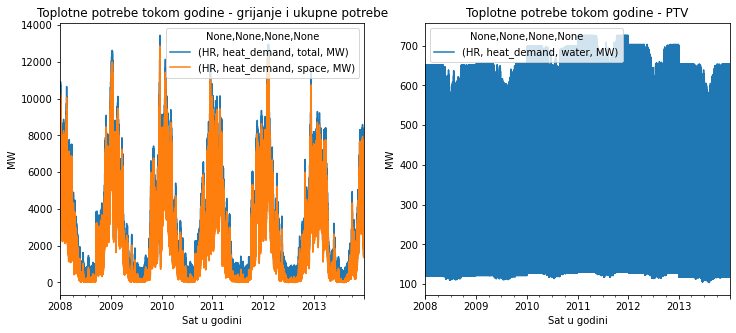

In [13]:
fig,ax=plt.subplots(ncols=2)
heat_demand=[('HR',  'heat_demand',         'total',          'MW'),(     'HR',  'heat_demand',         'space',          'MW')]
file[file["Year"]<2014].plot(x=('country',     'variable',     'attribute',        'unit'),y=heat_demand,figsize=(12,5),ax=ax[0])
ax[0].set_xlabel("Sat u godini")
ax[0].set_ylabel("MW")
ax[0].set_title("Toplotne potrebe tokom godine - grijanje i ukupne potrebe")


water_demand=[(     'HR',  'heat_demand',         'water',          'MW')]
file[file["Year"]<2014].plot(x=('country',     'variable',     'attribute',        'unit'),y=water_demand,figsize=(12,5),ax=ax[1])
ax[1].set_xlabel("Sat u godini")
ax[1].set_ylabel("MW")
ax[1].set_title("Toplotne potrebe tokom godine - PTV")
plt.show()

In [14]:


file=file[(file["Year"]>2007)&(file["Year"]<2014)]

yearly_demand=file.groupby("Year")[[(     'HR',  'heat_demand',     'total',          'MW'),(     'HR',  'heat_demand',         'space',          'MW'),(     'HR',  'heat_demand',         'water',          'MW')]].sum()/1000000
col_demand_heat=[(     'HR',  'heat_demand',     'space_COM',          'MW'),
            (     'HR',  'heat_demand',     'space_MFH',          'MW'),
            (     'HR',  'heat_demand',     'space_SFH',          'MW')]

#yearly_demand=file.groupby("Year")[('HR',  'heat_demand',         'total',          'MW'),(     'HR',  'heat_demand',         'space',          'MW'),(     'HR',  'heat_demand',         'water',          'MW')].sum()
#col_demand_heat=[(     'HR',  'heat_demand',     'space_COM',          'MW'),
            #(     'HR',  'heat_demand',     'space_MFH',          'MW'),
           # (     'HR',  'heat_demand',     'space_SFH',          'MW')]
heat_space=file.groupby("Year")[col_demand_heat].sum()/1000000

Najveći udio u godišnjim potrebama za grijanje čine individualni objekti. Napomena: legenda na dijagramima je u MW jer je to dio imena kolona koja će se naknadno promijeniti. Odgovrajuće vrijednosti su u TW, kako je naznačeno na y-osi. Najanje toplotne potrebe su za zgrade uslužnih djelatnosti.

Text(0.5, 1.0, 'Godišnje toplotne potrebe u TW')

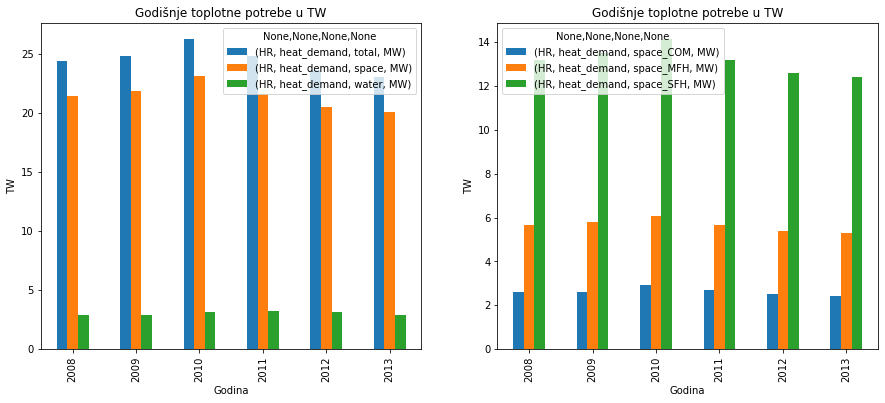

In [15]:
fig,ax=plt.subplots(ncols=2,figsize=(15,6))
yearly_demand.plot.bar(ax=ax[0])
ax[0].set_xlabel("Godina")
ax[0].set_ylabel("TW")
ax[0].set_title("Godišnje toplotne potrebe u TW")

heat_space.plot.bar(ax=ax[1])
ax[1].set_xlabel("Godina")
ax[1].set_ylabel("TW")
ax[1].set_title("Godišnje toplotne potrebe u TW")


Ukupno toplotno opterećnje veće od 6000 MW traje oko 1500 sati godišnje.

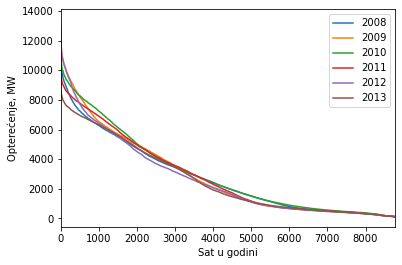

<Figure size 1440x720 with 0 Axes>

In [16]:
years=[2008,2009,2010,2011,2012,2013]
ax=plt.gca()
fig=plt.figure(figsize=(20,10))
for i,year in enumerate(years):
    duration_curve=file[file["Year"]==year]
    duration_curve=duration_curve.sort_values(by=(     'HR',  'heat_demand',         'total',          'MW'), ascending=False)
    ax.plot(np.arange(len(duration_curve)),duration_curve[(     'HR',  'heat_demand',         'total',          'MW')],label=year,)
   
    ax.legend()
    ax.set_xlabel("Sat u godini")
    ax.set_ylabel("Opterećenje, MW")
    ax.margins(x=0)
    ax.set_xticks(np.arange(0,9000,1000))
plt.show() 

Prosječni dnevni profil grijnih potreba je dat na sljedećem dijagramu za sve tipove objekata. Vršno opterećenje se dešava ujutru, kada startaju sistemi,te u poslijepodnevnim satima kada ljudi borave u stambenim objektima.Potrebe objekata uslužnih djelatnosti su znatno manje od potreba zagrijavanja stambenih objekata, te se u tom slučaju bilježi značajan pad za stambene objekte u periodu od 5 do 11h. Sličan trend se bilježi i kod potrošnje PTV. Srednje vršno opterećenje za grijanje iznosi 2000 MW, a u slučaju PTV nešto više od 600 MW.

C:\Users\Ehlimana\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


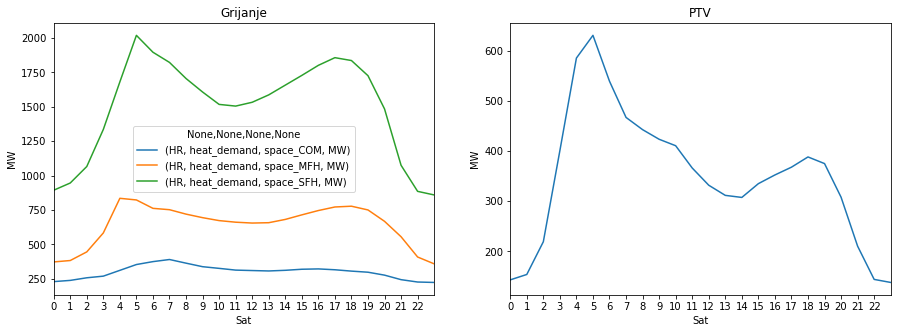

In [17]:
fig,ax=plt.subplots(ncols=2,figsize=(15,5))

file.groupby("Hour")[col_demand_heat].mean().plot.line(ax=ax[0])
ax[0].margins(x=0)
ax[0].set_xticks(np.arange(0,23,1))
ax[0].set_ylabel("MW")
ax[0].set_xlabel("Sat")
ax[0].set_title("Grijanje")

file.groupby("Hour").mean()[(     'HR',  'heat_demand',         'water',          'MW')].plot.line(ax=ax[1])
ax[1].margins(x=0)
ax[1].set_xticks(np.arange(0,23,1))
ax[1].set_ylabel("MW")
ax[1].set_xlabel("Sat")
ax[1].set_title("PTV")
plt.show()

In [18]:
#file.plot(x=('country',     'variable',     'attribute',        'unit'),y=[(                  'HR', 'heat_profile', 'space_COM', 'MW/TWh'),
          #  (                  'HR', 'heat_profile', 'space_MFH', 'MW/TWh'),
          #  (                  'HR', 'heat_profile', 'space_SFH', 'MW/TWh')],figsize=(15,8))

Iz iste baze podataka je moguće izvući temperaturu zraka, direktno i difuzno Sunčevo zračenje. Trenutna analiza će se odnositi samo na temperaturu zraka. Ovi podaci su dostupni u satnoj rezoluciji od 1980 - 2018.

In [19]:
file_weather=pd.read_csv(r"FILES\HEAT\weather_data.csv",parse_dates=True,header=0)

In [20]:
file_weather.columns[(file_weather.columns.str.contains("HR"))]

Index(['HR_temperature', 'HR_radiation_direct_horizontal',
       'HR_radiation_diffuse_horizontal'],
      dtype='object')

In [21]:
col_HR=file_weather[file_weather.columns[(file_weather.columns.str.contains("HR"))|(file_weather.columns.str.contains("utc_timestamp"))]]

In [22]:
col_HR.head(3)

,utc_timestamp,HR_temperature,HR_radiation_direct_horizontal,HR_radiation_diffuse_horizontal
0,1980-01-01T00:00:00Z,-0.880,0.0,0.0
1,1980-01-01T01:00:00Z,-0.888,0.0,0.0
2,1980-01-01T02:00:00Z,-0.950,0.0,0.0


Za ovaj fajl je potrebno prilagoditi format datuma kako bi se iz njega dobile korisne informacije.

In [23]:
pd.set_option('mode.chained_assignment', None)

In [24]:
d=[]

from datetime import datetime
for value1 in col_HR.iloc[:,0]:
    value1=value1.replace('Z', '')
    value1=datetime.fromisoformat(value1)
    value1.strftime('%Y-%m-%d %H:%M:%S')
    d.append(value1)

In [25]:
col_HR.iloc[:,0]=d

In [26]:
col_HR.iloc[:,0]=pd.to_datetime(col_HR.iloc[:,0],utc=True)

In [27]:
col_HR.head()

,utc_timestamp,HR_temperature,HR_radiation_direct_horizontal,HR_radiation_diffuse_horizontal
0,1980-01-01 00:00:00+00:00,-0.880,0.0,0.0
1,1980-01-01 01:00:00+00:00,-0.888,0.0,0.0
2,1980-01-01 02:00:00+00:00,-0.950,0.0,0.0
3,1980-01-01 03:00:00+00:00,-1.157,0.0,0.0
4,1980-01-01 04:00:00+00:00,-1.468,0.0,0.0


In [28]:
pd.set_option('mode.chained_assignment', None)

In [29]:
col_HR["Year"]=col_HR.iloc[:,0].dt.year
col_HR["Month"]=col_HR.iloc[:,0].dt.month
col_HR["Dayofyear"]=col_HR.iloc[:,0].dt.dayofyear
col_HR["Dayofmonth"]=col_HR.iloc[:,0].dt.day
col_HR["Hour"]=col_HR.iloc[:,0].dt.hour

In [30]:
col_HR.head(3)

,utc_timestamp,HR_temperature,HR_radiation_direct_horizontal,HR_radiation_diffuse_horizontal,Year,Month,Dayofyear,Dayofmonth,Hour
0,1980-01-01 00:00:00+00:00,-0.880,0.0,0.0,1980,1,1,1,0
1,1980-01-01 01:00:00+00:00,-0.888,0.0,0.0,1980,1,1,1,1
2,1980-01-01 02:00:00+00:00,-0.950,0.0,0.0,1980,1,1,1,2


Za temperaturu zraka će se odabrati podaci od 2008. do 2013. jer su u tom periodu dostupne toplotne potrebe.

In [31]:
col_HR[(col_HR["Year"]>=2008)&(col_HR["Year"]<=2013)].head(3)

,utc_timestamp,HR_temperature,HR_radiation_direct_horizontal,HR_radiation_diffuse_horizontal,Year,Month,Dayofyear,Dayofmonth,Hour
245448,2008-01-01 00:00:00+00:00,-4.649,0.0,0.0,2008,1,1,1,0
245449,2008-01-01 01:00:00+00:00,-4.793,0.0,0.0,2008,1,1,1,1
245450,2008-01-01 02:00:00+00:00,-4.924,0.0,0.0,2008,1,1,1,2


Sa narednog dijagrama se može vidjeti očekivani pad toplotnih potreba sa porastom temperature zraka i obrnuto, te će se kasnije prikazati i negativna korelacija.

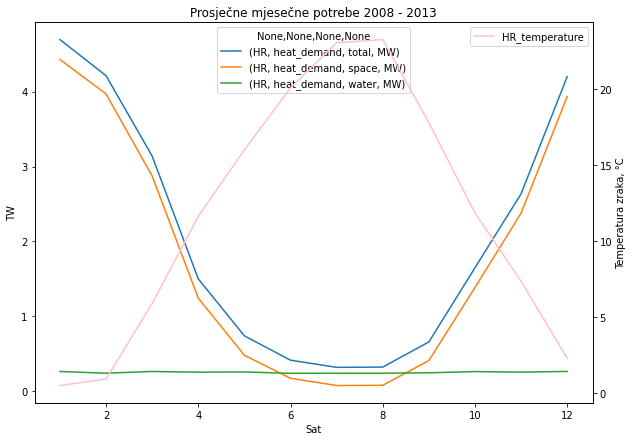

In [32]:
years=col_HR[(col_HR["Year"]>=2008)&(col_HR["Year"]<=2013)]
ax=plt.gca()

cols_total=[('HR',  'heat_demand',         'total',          'MW'),(     'HR',  'heat_demand',         'space',          'MW'),(     'HR',  'heat_demand',         'water',          'MW')]

plot_file=file.groupby(["Month","Year"])[cols_total].sum()

(plot_file.groupby(["Month"])[cols_total].mean()/1000000).plot(kind="line",ax=ax,figsize=(10,7))
ax_1=ax.twinx()

years[(years["Year"]>=2008)&(years["Year"]<=2013)].groupby("Month")["HR_temperature"].mean().plot(kind="line",ax=ax_1,color="pink")
ax.set_xlabel("Sat")
ax.set_ylabel("TW")
ax.set_title("Prosječne mjesečne potrebe 2008 - 2013")
ax_1.set_ylabel("Temperatura zraka, °C")
ax_1.legend()
plt.show()

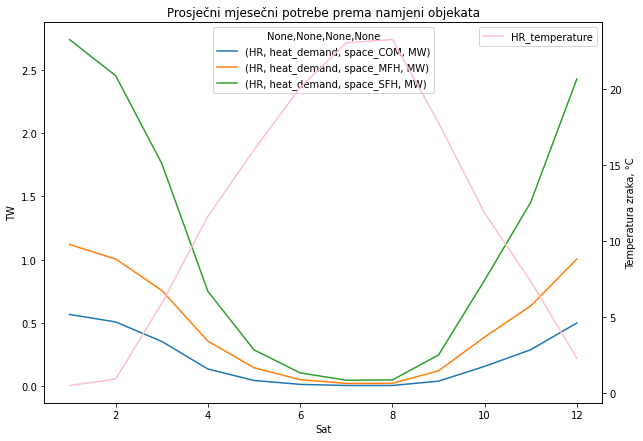

In [33]:
years=col_HR[(col_HR["Year"]>=2008)&(col_HR["Year"]<=2013)]
ax=plt.gca()
plot_file=file.groupby(["Month","Year"])[col_demand_heat].sum()
(plot_file.groupby("Month").mean()/1000000).plot(kind="line",ax=ax,figsize=(10,7))
ax_1=ax.twinx()

years[(years["Year"]>=2008)&(years["Year"]<=2013)].groupby("Month")["HR_temperature"].mean().plot(kind="line",ax=ax_1,color="pink")
ax.set_xlabel("Sat")
ax.set_ylabel("TW")
ax.set_title("Prosječni mjesečni potrebe prema namjeni objekata")
ax_1.set_ylabel("Temperatura zraka, °C")
ax_1.legend()
plt.show()

In [34]:
cols=cols_total+col_demand_heat

heat_0818=file[cols].reset_index()
col_HR_0818=col_HR[(col_HR["Year"]>=2008)&(col_HR["Year"]<=2018)][["utc_timestamp","HR_temperature","Year","Month"]].reset_index()
years1=pd.concat([heat_0818,col_HR_0818],axis=1)
years1=years1.dropna()

In [35]:
years1.head(2)

,"(index, , , )","(HR, heat_demand, total, MW)","(HR, heat_demand, space, MW)","(HR, heat_demand, water, MW)","(HR, heat_demand, space_COM, MW)","(HR, heat_demand, space_MFH, MW)","(HR, heat_demand, space_SFH, MW)",index,utc_timestamp,HR_temperature,Year,Month
0,2.0,5377.0,5235.0,142.0,808.0,1211.0,3217.0,245448,2008-01-01 00:00:00+00:00,-4.649,2008,1
1,3.0,5516.0,5376.0,140.0,824.0,1231.0,3321.0,245449,2008-01-01 01:00:00+00:00,-4.793,2008,1


Minimalne potrbebe za grijanjem prostora su zabilježene pri temperaturama od oko 23- 24°C, a  maksimalne pri temperaturama nižim od -10°C.

In [36]:
for k,col in enumerate(cols):
    print(years1[years1[col]==years1[col].min()].iloc[:,[8,k+1,9]])

                  utc_timestamp  (HR, heat_demand, total, MW)  HR_temperature
49078 2013-08-06 22:00:00+00:00                         106.0          24.623
49102 2013-08-07 22:00:00+00:00                         106.0          24.571
                  utc_timestamp  (HR, heat_demand, space, MW)  HR_temperature
49102 2013-08-07 22:00:00+00:00                           2.0          24.571
49103 2013-08-07 23:00:00+00:00                           2.0          23.991
49104 2013-08-08 00:00:00+00:00                           2.0          23.456
                  utc_timestamp  (HR, heat_demand, water, MW)  HR_temperature
49054 2013-08-05 22:00:00+00:00                         104.0          23.781
49078 2013-08-06 22:00:00+00:00                         104.0          24.623
49102 2013-08-07 22:00:00+00:00                         104.0          24.571
                  utc_timestamp  (HR, heat_demand, space_COM, MW)  \
3243  2008-05-15 03:00:00+00:00                               1.0   
3267

In [37]:
for k,col in enumerate(cols):
   
    print(years1[years1[col]==years1[col].max()].iloc[:,[8,k+1,9]])

                  utc_timestamp  (HR, heat_demand, total, MW)  HR_temperature
17261 2009-12-20 05:00:00+00:00                       13450.0         -11.066
                  utc_timestamp  (HR, heat_demand, space, MW)  HR_temperature
17261 2009-12-20 05:00:00+00:00                       12869.0         -11.066
                  utc_timestamp  (HR, heat_demand, water, MW)  HR_temperature
26381 2011-01-04 05:00:00+00:00                         726.0          -5.767
26429 2011-01-06 05:00:00+00:00                         726.0          -4.038
26549 2011-01-11 05:00:00+00:00                         726.0           2.994
26597 2011-01-13 05:00:00+00:00                         726.0           1.051
26717 2011-01-18 05:00:00+00:00                         726.0           1.907
26765 2011-01-20 05:00:00+00:00                         726.0           0.271
26885 2011-01-25 05:00:00+00:00                         726.0          -6.771
26933 2011-01-27 05:00:00+00:00                         726.0   

Pearsonov koeficijent korelacije kao mjera linearne veze ukazuje na negativnu zavisnost. Nizak koeficijent korelacije je u slučaju potreba za PTV jer su one manje podložne sezonskim promjenama.

In [38]:
for col in cols:
    print(col,"Temperature correlation:")
    print(years1["HR_temperature"].corr(years1[col]))

('HR', 'heat_demand', 'total', 'MW') Temperature correlation:
-0.8258342154752158
('HR', 'heat_demand', 'space', 'MW') Temperature correlation:
-0.8358638272423864
('HR', 'heat_demand', 'water', 'MW') Temperature correlation:
-0.04568713562505972
('HR', 'heat_demand', 'space_COM', 'MW') Temperature correlation:
-0.8430491780555925
('HR', 'heat_demand', 'space_MFH', 'MW') Temperature correlation:
-0.8408678783670563
('HR', 'heat_demand', 'space_SFH', 'MW') Temperature correlation:
-0.8283760272030392


Normalizirane vrijednosti trenutnih naspram ukupnih godišnjih potreba za svaku godinu u periodu 2008 - 2013 će se ponovo izračunati i spasiti u obliku MW/TWh (scaled_columns)

In [39]:
#scaled_factors=pd.DataFrame()

scaled_columns=["total_heat_demand_MW/TWh","space_heat_demand_MW/TWh","water_heat_demand_MW/TWh","space_COM_demand_MW/TWh",
               "space_MFH_demand_MW/TWh","space_SFH_demand_MW/TWh"]


years1=years1.assign(**dict([(_,None) for _ in scaled_columns]))
years_list=[2008,2009,2010,2011,2012,2013]
for year in years_list:
    sum_year=years1[years1["Year"]==year][cols].sum(axis=0)
    
    years1.loc[years1["Year"]==year,scaled_columns]=(years1[years1["Year"]==year][cols].div(sum_year/1000000)).astype(float).values
   
    years1.loc[years1["Year"]==year,"Hourofyear"]=np.arange(len(years1[years1["Year"]==year]))
    
years1[scaled_columns]=years1[scaled_columns].astype(float)

## Opcija 1: Toplotne potrebe - BiH

Iz Tipologije stambenih zgrada i Tipologije javnih objekata (biće navedena referenca) pronađeni su podaci o procijenjenim godišnjim potrebama za grijanjem prostora u BiH, s tim da javne zgrade ne odgovaraju svim zgradama uslužnih djelatnosti, ali je jedini poznat podatak. Također, ovdje nisu uključene toplotne potrebe za PTV, već se one odnose samo na grijanje prostora. Nadalje, potrebno je dodatno sagledati energetski bilans BiH za 2019./2020. i 2021.

In [40]:
BH_demand=years1.groupby("Hourofyear")[scaled_columns].mean()

In [41]:
# Bosnia - residential buildings #annually - source: typology of residential buildings 19593880 mwh/god #arbitrary year

SFH=(16698261+369706)/1000000, 
MFH=(960738+197893+1274382+92900)/1000000
COM=1683423/1000000

In [42]:
BH_demand.columns

Index(['total_heat_demand_MW/TWh', 'space_heat_demand_MW/TWh',
       'water_heat_demand_MW/TWh', 'space_COM_demand_MW/TWh',
       'space_MFH_demand_MW/TWh', 'space_SFH_demand_MW/TWh'],
      dtype='object')

Sada će se iskoristiti normalizirani podaci Hrvatske i pomnožit će se sa ukupnim godišnjim potrebama za dati tip objekata u BiH kako bi se dobile trenutne potrebe za grijanjem.Ovo je obrnut proces u odnosu na način na koji su se dobile normalizirane vrijednosti.

In [43]:
space_heat_scaled=['space_COM_demand_MW/TWh',
       'space_MFH_demand_MW/TWh', 'space_SFH_demand_MW/TWh']

BH_demand["heat_demand, space_COM, MW"]=BH_demand['space_COM_demand_MW/TWh']*COM
BH_demand["heat_demand, space_MFH, MW"]=BH_demand['space_MFH_demand_MW/TWh']*MFH
BH_demand["heat_demand, space_SFH, MW"]=BH_demand['space_SFH_demand_MW/TWh']*SFH

BH_demand['heat_demand', 'space', 'MW']=BH_demand["heat_demand, space_COM, MW"]+BH_demand["heat_demand, space_MFH, MW"]+BH_demand["heat_demand, space_SFH, MW"]

In [44]:
BH_demand.head(2)

,total_heat_demand_MW/TWh,space_heat_demand_MW/TWh,water_heat_demand_MW/TWh,space_COM_demand_MW/TWh,space_MFH_demand_MW/TWh,space_SFH_demand_MW/TWh,"heat_demand, space_COM, MW","heat_demand, space_MFH, MW","heat_demand, space_SFH, MW","(heat_demand, space, MW)"
Hourofyear,,,,,,,,,,
0.0,177.587680,195.978876,48.784742,241.659163,177.748360,194.729872,406.814593,448.976892,3323.643033,4179.434518
1.0,181.742356,200.976037,47.157290,245.085555,179.657618,201.355110,412.582660,453.799514,3436.722381,4303.104555


Text(0.5, 1.0, 'Godišnje potrebe BiH - javni i stambeni objekti ')

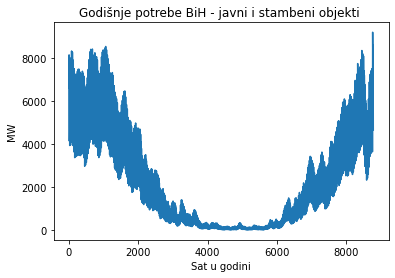

In [45]:
BH_demand['heat_demand', 'space', 'MW'].plot()
plt.xlabel("Sat u godini")
plt.ylabel("MW")
plt.title("Godišnje potrebe BiH - javni i stambeni objekti ")

## Opcija 2: Demandlib biblioteka

Istraživanjem seta podataka when2heat, od istih autora je pronađena Python biblioteka koja radi na sličnom principu kao i proračun koji je izvršen za 16 zemalja.  Osnova su podaci o distribuciji gasa u Njemačkoj, s tim da se kao ulaz koriste još i praznici, te da li je područje vjetrovito ili ne. Zasad će se istraživanje bazirati samo na unos praznika za 2019. i toplotnih potreba po objektima za BiH koje su prethodno navedene. U budućnosti se mogu klimatski podaci preuzeti i sa websitea NASA-e, te možda djelimično od FHMZ.

In [46]:
#%pip install demandlib

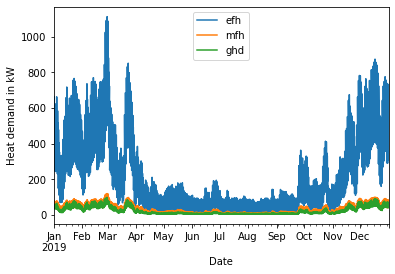

Annual consumption: 
efh    1.948479e+06
mfh    2.883422e+05
ghd    1.921783e+05
dtype: float64
                            efh        mfh        ghd
2019-01-01 00:00:00  262.401445  36.730435  36.664618
2019-01-01 01:00:00  268.181212  39.055146  36.125432
2019-01-01 02:00:00  277.428840  39.520088  41.085939
2019-01-01 03:00:00  299.391957  42.464722  49.820745
2019-01-01 04:00:00  366.437260  52.848431  59.202574
...                         ...        ...        ...
2019-12-31 19:00:00  644.582183  81.545199  52.145165
2019-12-31 20:00:00  613.948574  79.718321  48.747234
2019-12-31 21:00:00  542.470154  72.742968  42.735511
2019-12-31 22:00:00  382.920109  63.442497  38.945511
2019-12-31 23:00:00  306.336087  46.668434  39.206891

[8760 rows x 3 columns]


In [47]:
#KOD SA BIBLIOTEKE

# -*- coding: utf-8 -*-
"""
Creating heat demand profiles using the bdew method.
Installation requirements
-------------------------
This example requires at least version v0.1.4 of the oemof demandlib. Install
by:
    pip install 'demandlib>=0.1.4,<0.2'
Optional:
    pip install matplotlib
SPDX-FileCopyrightText: Birgit Schachler
SPDX-FileCopyrightText: Uwe Krien <krien@uni-bremen.de>
SPDX-FileCopyrightText: jnnr
SPDX-FileCopyrightText: Stephen Bosch
SPDX-License-Identifier: MIT
"""
import datetime
import os

import demandlib.bdew as bdew

# read example temperature series
filename = "example_data.csv"
dirname = os.getcwd()
datapath = os.path.join(dirname, filename)

if not os.path.isfile(datapath):
    msg = (
        "The file {0} could not be found in the current working directory.\n "
        "This could happen due to the following reasons:\n"
        "* you forgot to download the example data from the repository\n"
        "* the filename is wrong\n"
        "* the file is not located in {1}\n"
        "Download the file from the demandlib repository and copy it to the "
        "right directory.\nAlternatively you can adapt the name of the file "
        "or the name of the directory in the example script."
    )
    print(msg.format(filename, dirname))
    exit(0)

temperature = pd.read_csv(datapath)["temperature"]


# The following dictionary is create by "workalendar"
# pip3 install workalendar
# >>> from workalendar.europe import Germany
# >>> cal = Germany()
# >>> holidays = dict(cal.holidays(2010))


ann_demands_per_type = {"efh": (16698261+369706)*1000/8760, "mfh": (960738+197893+1274382+92900)*1000/8760, "ghd": 1683423*1000/8760}

holidays = {
   
  
    datetime.date(2019, 1, 1): "New year",
    datetime.date(2019, 1, 2): "New year",
    datetime.date(2019, 1, 7): "Christmas Day",
    datetime.date(2019, 12, 25): "Christmas Day",
    datetime.date(2019, 4, 21): "Easter",
    datetime.date(2019, 4, 28): "Easter",

    datetime.date(2019, 5, 1): "Labour Day",
    datetime.date(2019, 5, 2): "Labour Day",
    datetime.date(2019, 6, 4): "Eid",
    datetime.date(2019, 8, 11): "Eid",
    
    datetime.date(2019, 11, 25): "Statehood",
    datetime.date(2019, 3, 1): "Independence",
    
}


# Create DataFrame for 2019
demand = pd.DataFrame(
    index=pd.date_range(
        datetime.datetime(2019, 1, 1, 0), periods=8760, freq="H"
    )
)

# Single family house (efh: Einfamilienhaus)
demand["efh"] = bdew.HeatBuilding(
    demand.index,
    holidays=holidays,
    temperature=temperature,
    shlp_type="EFH",
    building_class=1,
    wind_class=1,
    annual_heat_demand=ann_demands_per_type["efh"],
    name="EFH",
).get_bdew_profile()

# Multi family house (mfh: Mehrfamilienhaus)
demand["mfh"] = bdew.HeatBuilding(
    demand.index,
    holidays=holidays,
    temperature=temperature,
    shlp_type="MFH",
    building_class=2,
    wind_class=0,
    annual_heat_demand=ann_demands_per_type["mfh"],
    name="MFH",
).get_bdew_profile()

# Industry, trade, service (ghd: Gewerbe, Handel, Dienstleistung)
demand["ghd"] = bdew.HeatBuilding(
    demand.index,
    holidays=holidays,
    temperature=temperature,
    shlp_type="ghd",
    wind_class=0,
    annual_heat_demand=ann_demands_per_type["ghd"],
    name="ghd",
).get_bdew_profile()

# Plot demand of building
ax = demand.plot()
ax.set_xlabel("Date")
ax.set_ylabel("Heat demand in kW")
plt.show()

print("Annual consumption: \n{}".format(demand.sum()))

print(demand)

for key in ann_demands_per_type:
    assert np.isclose(demand[key].sum(), ann_demands_per_type[key], rtol=1e-4)

## Opcija 3: Predviđanje na osnovu temperature

Opcija 3 se odnosi na korištenje podataka o temperaturi zraka kako bi se napravio model koji na osnovu temperature zraka predviđa potrebe za toplotom. Kada bi se podaci iz Hrvatske normalizirali i posmatrali u ovisnosti od temperature, stvorio bi se referentni model. Nakon toga bi se unosom temperature zraka iz 2019, 2020, ili 2021. vršilo predviđanje potreba, s tim da je upitno koliko bi taj model bio drugačiji od Opcije 1 jer su osim temperature zraka bitne i mjere energetske efikanosti koje su se provele u međuvremenu. Nakon toga bi se ponovio postupak za dobijanje toplotnih potreba BiH. Za sada ova opcija može biti samo u domeni potencijalnog istraživanja....

In [48]:
coltemp=['HR_temperature']+scaled_columns

In [49]:
print(coltemp)

['HR_temperature', 'total_heat_demand_MW/TWh', 'space_heat_demand_MW/TWh', 'water_heat_demand_MW/TWh', 'space_COM_demand_MW/TWh', 'space_MFH_demand_MW/TWh', 'space_SFH_demand_MW/TWh']


In [50]:
train_size = int(0.85 * len(years1))
test_size = len(years1) - train_size
coltemp=['HR_temperature']+scaled_columns
univariate_df = years1[coltemp].copy()
#univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1:])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1:])

print(len(train), len(x_valid))

44716 7892


In [51]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import AdaBoostRegressor

In [52]:
model=MultiOutputRegressor(AdaBoostRegressor(random_state=0, n_estimators=10000)).fit(x_train,y_train)
print(model.score(x_train,y_train))

0.6461143110564211


In [53]:
y_pred=model.predict(x_valid)

In [57]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
#%pip install xgboost

In [58]:
score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print('RMSE: {}'.format(score_rmse))

RMSE: 50.786789495569515


In [60]:
y_pred[5]

array([193.24642119, 206.13712136, 120.02435454, 223.09258599,
       203.36675483, 214.75540975])